In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.transform import Rotation
from tqdm import tqdm

In [2]:
original_df = pd.read_hdf(r"J:\Alja Podgornik\Multimaze arena\Cohort 1_June 2020\all_videos\processed\chr8_day3DLC_resnet152_dlc_realApr6shuffle4_110000.h5")
original_df.columns = original_df.columns.droplevel(0)
main_df = pd.read_hdf(r"J:\Alja Podgornik\Multimaze arena\Cohort 1_June 2020\all_videos\processed\chr8_day3DLC_resnet152_dlc_realApr6shuffle4_110000.h5")
main_df.columns = main_df.columns.droplevel(0)
df = main_df
# df.head()

In [3]:
original_df = pd.read_hdf(r"J:\Alja Podgornik\Multimaze arena\Cohort 1_June 2020\all_videos\processed\chr8_day3DLC_resnet152_dlc_realApr6shuffle4_110000.h5")
original_df.columns = original_df.columns.droplevel(0)
# original_df

In [4]:
# pd.options.mode.chained_assignment = None  # default='warn'

center = df['center']

for bodypart in df.columns.levels[0]:
    for axis in df.columns.levels[1][1:]:
        df.loc[:, (bodypart, axis)] = df.loc[:, (bodypart, axis)] - center.loc[:, axis]
        
# df

In [5]:
rotated = pd.DataFrame(index=df.index, columns=df.columns)
angles = np.arctan2(df[('tail_base', 'y')], df['tail_base', 'x'])
# angles = np.where(angles<0, angles+2*np.pi, angles)

for bodypart in tqdm(df.columns.levels[0]):
    bp_df = df.loc[:, bodypart]
    bp_x = bp_df['x']
    bp_y = bp_df['y']
    bp_likelihood = bp_df['likelihood']
    cos = np.cos(angles)
    sin = np.sin(angles)
    for axis in bp_df.columns:
        if axis == 'x':
            rotated.loc[:, (bodypart, axis)] = (bp_x * cos) + (bp_y * sin)
        elif axis == 'y':
            rotated.loc[:, (bodypart, axis)] = (bp_y * cos) - (bp_x * sin)
        elif axis == 'likelihood':
            rotated.loc[:, (bodypart, axis)] = bp_likelihood

rotated
df = rotated

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.03it/s]


In [6]:
df = df.drop(columns=['paw_f_left', 'paw_f_right', 'paw_h_left', 'paw_h_right', 'tail_tip', 'tail_mid'], level=0)

In [7]:
high_likelihood = df.loc[:, df.columns.get_level_values(1) == 'likelihood'] > 0.7
high_likelihood = df.loc[high_likelihood.all(axis=1), :]
high_likelihood = high_likelihood.drop(columns='likelihood', level=1)

In [8]:
print(len(high_likelihood))

14412


In [9]:
skeleton = [['snout', 'left_ear'], ['snout', 'right_ear'], ['right_ear', 'left_ear'], ['left_ear', 'left_side'],
           ['right_ear', 'right_side'], ['right_side', 'tail_base'], ['left_side', 'tail_base'], ['center', 'left_ear'],
            ['center', 'right_ear'], ['center', 'right_side'], ['left_side', 'center'], ['tail_base', 'center']]

In [10]:
def plotter(to_plot, skeleton, indexes, plot_original_df=False, original_df=None, lim_min=-800, lim_max=800, limits=True):
    plt.figure(figsize=(32,32))
    indexcounter=1
    for i in indexes:
        
        plt.subplot(4,4,indexcounter)
        
        for bp in df.columns.get_level_values(0):
            
            plt.scatter(x=to_plot.loc[i, (bp, 'x')], y=to_plot.loc[i, (bp, 'y')], cmap='jet', )
            if plot_original_df:
                plt.scatter(x=original_df.loc[i, (bp, 'x')], y=original_df.loc[i, (bp, 'y')], cmap='jet', marker='*')
        
        for bp_pair in skeleton:
            
            plt.plot([to_plot.loc[i, (bp_pair[0], 'x')], to_plot.loc[i, (bp_pair[1], 'x')]],
                    [to_plot.loc[i, (bp_pair[0], 'y')], to_plot.loc[i, (bp_pair[1], 'y')]],
                    color = 'k', linestyle='-', linewidth=1)
            if plot_original_df:
                plt.plot([original_df.loc[i, (bp_pair[0], 'x')], original_df.loc[i, (bp_pair[1], 'x')]],
                    [original_df.loc[i, (bp_pair[0], 'y')], original_df.loc[i, (bp_pair[1], 'y')]],
                    color = 'k', linestyle='-', linewidth=1)

        indexcounter +=1
        if limits:
            plt.xlim(lim_min, lim_max)
            plt.ylim(lim_min, lim_max)
        plt.title('index:' + str(i), fontsize=18)
    
    plt.tight_layout()
    plt.show()

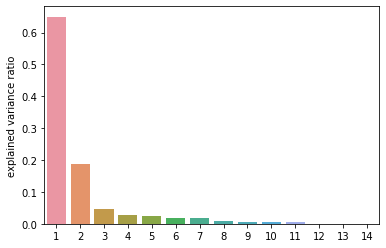

In [11]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, svd_solver='full')

pca_transformed = pca.fit_transform(high_likelihood)

expVar = pd.DataFrame(data=pca.explained_variance_ratio_, columns=['explained variance ratio'])
expVar
sns.barplot(data=expVar, y='explained variance ratio', x=list(range(1, len(expVar)+1)))

In [236]:
pca_transformed_df = pd.DataFrame(data=pca_transformed, columns=list(range(1, len(expVar)+1)),
                               index=high_likelihood.index)
pca_transformed_df = pca_transformed_df.iloc[:, :7]
pca_transformed_df

,1,2,3,4,5,6,7
7,1.822378,1.645462,1.145441,-0.179554,0.697972,-0.142307,-1.279971
8,1.740749,1.573039,0.937400,-0.322892,0.375433,-0.136642,-0.655784
9,1.752322,1.554453,0.924272,-0.146593,0.168826,-0.139320,-0.675941
10,1.922642,1.724589,0.992998,0.328305,-0.019240,0.175652,-1.241070
11,1.930704,1.643186,0.828839,0.535743,-0.096769,0.032711,-1.526981
...,...,...,...,...,...,...,...
101268,2.435143,2.228671,0.664034,1.010988,-2.413867,-1.189614,2.399481
101403,1.766829,1.311989,-0.429341,0.095778,-2.280683,-1.339297,0.792624
101475,2.249084,2.869714,-0.511628,1.772242,-2.363101,-0.460839,0.523001
101490,-1.532820,1.080712,-0.641443,0.107450,1.423519,-0.510751,0.099956


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=35, n_iter=25000, n_iter_without_progress=500, init='random', n_jobs=-1,
           verbose=1)

start_time = time.time()
transformed = tsne.fit_transform(pca_transformed_df)
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))

transformed = pd.DataFrame(transformed, columns=['x','y'], index=pca_transformed_df.index)
sns.scatterplot(data=transformed, x='x', y='y')

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 14412 samples in 0.023s...
[t-SNE] Computed neighbors for 14412 samples in 1.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14412
[t-SNE] Computed conditional probabilities for sample 2000 / 14412
[t-SNE] Computed conditional probabilities for sample 3000 / 14412
[t-SNE] Computed conditional probabilities for sample 4000 / 14412
[t-SNE] Computed conditional probabilities for sample 5000 / 14412
[t-SNE] Computed conditional probabilities for sample 6000 / 14412
[t-SNE] Computed conditional probabilities for sample 7000 / 14412
[t-SNE] Computed conditional probabilities for sample 8000 / 14412
[t-SNE] Computed conditional probabilities for sample 9000 / 14412
[t-SNE] Computed conditional probabilities for sample 10000 / 14412
[t-SNE] Computed conditional probabilities for sample 11000 / 14412
[t-SNE] Computed conditional probabilities for sample 12000 / 14412
[t-SNE] Computed conditional probabilities for sa

In [ ]:
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=15)
start_time = time.time()
kde.fit(transformed)
print("fitted in --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
scores = kde.score_samples(transformed)
print("scored in --- %s seconds ---" % (time.time() - start_time))
# transformed['score'] = np.exp(scores)

In [ ]:
x = np.linspace(transformed['x'].min(), transformed['x'].max(), 100)
y = np.linspace(transformed['y'].min(), transformed['y'].max(), 100)
X, Y = np.meshgrid(x, y)

xy = np.vstack([X.ravel(), Y.ravel()]).T

Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

In [ ]:
plt.figure()
plt.contourf(X, Y, Z, 12, cmap='afmhot_r')
plt.colorbar()

In [ ]:
from ipywidgets import interact
import pims

path_video = r"J:\Alja Podgornik\Multimaze arena\Cohort 1_June 2020\all_videos\processed\chr8_day3.mp4"
video = pims.Video(path_video)

In [ ]:
@interact
def checkRegion(xmin:(X.min(), X.max()), xmax:(X.min(), X.max()), ymin:(Y.min(), Y.max()), ymax:(Y.min(), Y.max()), lev:(0,30)):
    plt.contourf(X, Y, Z, lev, cmap='afmhot_r')
    plt.colorbar()
    plt.axhline(ymin)
    plt.axhline(ymax)
    plt.axvline(xmin)
    plt.axvline(xmax)
    print("ymin, ymax, xmin, xmax =", (ymin, ymax, xmin, xmax))

In [ ]:
# ymin, ymax, xmin, xmax = (87.35338, 96.75338, -45.3079, -29.9079)

# x_filtered = transformed[(transformed['x'] > xmin) & (transformed['x'] < xmax)]
# y_filtered = x_filtered[(x_filtered['y'] > ymin) & (x_filtered['y'] < ymax)]
# filtered_subset = y_filtered.sample(16)
# print(filtered_subset.index)
# plotter(high_likelihood, skeleton, filtered_subset.index, lim_min=-150, lim_max=150)

In [ ]:
# folder = r"C:\Users\serce\Desktop\inspect"
# region = 'region5'

# for frame_no in filtered_subset.index[:4]:
#     frame = video[frame_no]
#     plt.imsave(os.path.join(folder, region, str(frame_no) + '.png'), arr=frame)

In [ ]:
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

image=Z
thresh = threshold_otsu(image)
binary = image > thresh

image=binary

distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False,
                            labels=image)

markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image, watershed_line=True)

plt.figure()
plt.imshow(np.flipud(labels), cmap='cubehelix_r')
plt.colorbar()
labels.shape

reshape labels?

In [134]:
Z.reshape(-1).shape

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
import pims
vid = pims.Video(r"J:\Alja Podgornik\Multimaze arena\Cohort 1_June 2020\all_videos\processed\chr8_day3.mp4")
frames = []
for index in filtered_subset.index:
    frames.append(vid[index])
    
outputfolder = r"C:\Users\serce\Desktop\inspect"

for n, frame in enumerate(frames):
    plt.imsave(r"C:\Users\serce\Desktop\inspect" + "\\" + str(n) + ".png", frame)

In [ ]:
print(original_df.iloc[39631])

In [ ]:
plt.imshow(Z)
plt.colorbar()

----------------------------------------

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=30, init='k-means++', n_init=30, max_iter=3000, tol=0.0001, algorithm='auto')
transformed_km = km.fit_transform(subset)

In [ ]:
sns.scatterplot(data=transformed, x='x', y='y', hue=km.labels_)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, svd_solver='full')

pca_transformed = pca.fit_transform(subset)

expVar = pd.DataFrame(data=pca.explained_variance_ratio_, columns=['explained variance ratio'])
expVar
sns.barplot(data=expVar, y='explained variance ratio', x=list(range(1,40)))

In [ ]:
sns.scatterplot(x=pca_transformed[:, 0], y=pca_transformed[:, 1], hue=km.labels_)

In [ ]:
#index = transformed[transformed['y'] < 28].index

#to_plot = df.iloc[index, :]

#plotter(subset, skeleton, to_plot.index[:16])

In [ ]:
pca_transformed.shape